# LSTM-Based Text Summarization Using CNN/DailyMail
Extractive & Abstractive Approaches in PyTorch

In this project, you will build:

- **Extractive Summarization:** A sentence classifier that picks the most summary-worthy sentence from a news article.

- **Abstractive Summarization:** An encoder-decoder (seq2seq) LSTM model that generates a summary.

We use the CNN/DailyMail dataset (version 3.0.0), which contains news articles paired with human-written highlights. For demonstration, we load a small subset of the dataset.



## 1. Setup & Data Loading
First, install the required libraries and load the dataset using Hugging Face’s datasets package.

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [2]:
import torch, re, random
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from datasets import load_dataset

torch.manual_seed(42)
random.seed(42)


### Load a Small Subset of CNN/DailyMail
For demonstration, we load the first 100 samples from the training split.

In [3]:
dataset = load_dataset("cnn_dailymail", "3.0.0", split="train[:100]")
print("Total samples loaded:", len(dataset))
print("Example keys:", dataset.features)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Total samples loaded: 100
Example keys: {'article': Value(dtype='string', id=None), 'highlights': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None)}


Each sample has two key fields:

**article:** the full news article (input text)

**highlights:** the human-written summary

## 2. Preprocessing & Vocabulary
We now preprocess the text:

- Tokenize articles and summaries using simple whitespace splitting.

- Build a vocabulary (including special tokens) based on our subset.

- Pad the sequences to a fixed length.



> Note: In a production setting, you might use a more advanced tokenizer (e.g., from Hugging Face’s tokenizers) and a pretrained embedding. For clarity, we use a simple tokenizer here.



### 2.1 Tokenization & Vocabulary

In [4]:
def tokenize(text):
    text = text.lower()
    text = text.split()
    return text



articles = [sample["article"] for sample in dataset]
summaries  = [sample["highlights"] for sample in dataset]

vocab = {"<pad>":0, "<unk>":1, "<sos>":2, "<eos>":3}
for text in articles + summaries:
    for token in tokenize(text):
        if token not in vocab:
            vocab[token] = len(vocab)
print("Vocabulary size:", len(vocab))


Vocabulary size: 13365


In [5]:
vocab

{'<pad>': 0,
 '<unk>': 1,
 '<sos>': 2,
 '<eos>': 3,
 'london,': 4,
 'england': 5,
 '(reuters)': 6,
 '--': 7,
 'harry': 8,
 'potter': 9,
 'star': 10,
 'daniel': 11,
 'radcliffe': 12,
 'gains': 13,
 'access': 14,
 'to': 15,
 'a': 16,
 'reported': 17,
 '£20': 18,
 'million': 19,
 '($41.1': 20,
 'million)': 21,
 'fortune': 22,
 'as': 23,
 'he': 24,
 'turns': 25,
 '18': 26,
 'on': 27,
 'monday,': 28,
 'but': 29,
 'insists': 30,
 'the': 31,
 'money': 32,
 "won't": 33,
 'cast': 34,
 'spell': 35,
 'him.': 36,
 'in': 37,
 '"harry': 38,
 'and': 39,
 'order': 40,
 'of': 41,
 'phoenix"': 42,
 'disappointment': 43,
 'gossip': 44,
 'columnists': 45,
 'around': 46,
 'world,': 47,
 'young': 48,
 'actor': 49,
 'says': 50,
 'has': 51,
 'no': 52,
 'plans': 53,
 'fritter': 54,
 'his': 55,
 'cash': 56,
 'away': 57,
 'fast': 58,
 'cars,': 59,
 'drink': 60,
 'celebrity': 61,
 'parties.': 62,
 '"i': 63,
 "don't": 64,
 'plan': 65,
 'be': 66,
 'one': 67,
 'those': 68,
 'people': 69,
 'who,': 70,
 'soon': 71,
 '

### 2.2 Encode & Pad Sequences
We restrict the maximum lengths for articles and summaries (for demonstration, adjust as needed).

In [6]:
def encode(tokens):
    return [vocab.get(token, vocab["<unk>"]) for token in tokens]

max_article_len = 512
max_summary_len = 64

def pad(seq, max_len):
    return seq + [vocab["<pad>"]] * (max_len - len(seq))

encoded_articles = []
encoded_summaries_in = []
encoded_summaries_out = []

for art, summ in zip(articles, summaries):
    art_tokens = tokenize(art)[:max_article_len]
    summ_tokens = tokenize(summ)[:(max_summary_len-1)]
    encoded_articles.append(pad(encode(art_tokens), max_article_len))
    # For the decoder: add <sos> and <eos>
    encoded_summaries_in.append(pad([vocab["<sos>"]] + encode(summ_tokens), max_summary_len))
    encoded_summaries_out.append(pad(encode(summ_tokens) + [vocab["<eos>"]], max_summary_len))

X = torch.tensor(encoded_articles, dtype=torch.long)
Y_in = torch.tensor(encoded_summaries_in, dtype=torch.long)
Y_out = torch.tensor(encoded_summaries_out, dtype=torch.long)
print("Articles tensor shape:", X.shape)
print("Summaries tensor shape:", Y_in.shape)


Articles tensor shape: torch.Size([100, 512])
Summaries tensor shape: torch.Size([100, 64])


## 3. Extractive Summarization
In extractive summarization, we select a sentence from the article that best matches the reference summary. Since CNN/DailyMail does not have extractive labels, we use a heuristic:
For each article, split it into sentences and select the sentence having the highest word-overlap with the summary as the “target” sentence.

### 3.1 Create Extractive Labels

In [7]:
def simple_sentence_split(text):
    # A simple (though not perfect) sentence splitter based on ". "
    return text.split(". ")

def label_extractive(article, summary):

    summ_set = set(tokenize(summary))
    sentences = simple_sentence_split(article)
    scores = []
    for s in sentences:
        s_tokens = set(tokenize(s))
        score = len(s_tokens & summ_set)
        scores.append(score)
    # Choose the sentence with the highest overlap score
    if scores:
        target_idx = scores.index(max(scores))
    else:
        target_idx = 0
    return sentences, target_idx

# Process a subset of articles for extractive training (e.g., first 20 samples)
extract_articles = articles[:20] #increase it later to check the performance of the model
extract_summaries = summaries[:20]

all_sentences = []
all_labels = []
for art, summ in zip(extract_articles, extract_summaries):
    sents, target_idx = label_extractive(art, summ)
    for idx, sentence in enumerate(sents):
        all_sentences.append(sentence)
        all_labels.append(1 if idx == target_idx else 0)

print("Total sentences:", len(all_sentences))
print("Total target sentences (label==1):", sum(all_labels))


Total sentences: 534
Total target sentences (label==1): 20


### 3.2 Encode & Pad Extractive Data

In [8]:
encoded_sents = [pad(encode(tokenize(s))[:50], 50) for s in all_sentences]
X_sent = torch.tensor(encoded_sents, dtype=torch.long)
y_sent = torch.tensor(all_labels, dtype=torch.long)
print("Extractive data shape:", X_sent.shape)


Extractive data shape: torch.Size([534, 50])


### 3.3 LSTM Classifier for Extractive Summarization
Define and train a simple LSTM-based sentence classifier.


In [9]:
class SentenceClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=64):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc   = nn.Linear(hidden_dim, 2)
    def forward(self, x):
        emb = self.embed(x)
        _, (h, _) = self.lstm(emb)
        return self.fc(h.squeeze(0))

model_cls = SentenceClassifier(len(vocab))
criterion_cls = nn.CrossEntropyLoss()
optimizer_cls = torch.optim.Adam(model_cls.parameters(), lr=0.001)

# Train for a few epochs (dataset is small)
for epoch in range(50):
    optimizer_cls.zero_grad()
    loss = criterion_cls(model_cls(X_sent), y_sent)
    loss.backward()
    optimizer_cls.step()
    if (epoch+1) % 10 == 0:
        preds = model_cls(X_sent).argmax(dim=1)
        acc = (preds == y_sent).float().mean().item()
        print(f"[Extractive] Epoch {epoch+1}: Loss {loss.item():.4f}, Accuracy {acc:.2f}")


[Extractive] Epoch 10: Loss 0.2114, Accuracy 0.96
[Extractive] Epoch 20: Loss 0.1601, Accuracy 0.96
[Extractive] Epoch 30: Loss 0.1626, Accuracy 0.96
[Extractive] Epoch 40: Loss 0.1591, Accuracy 0.96
[Extractive] Epoch 50: Loss 0.1567, Accuracy 0.96


### 3.4 Inference for Extractive Summarization
For a given article, split into sentences and use the classifier to pick the best sentence.

In [10]:
model_cls.eval()
def extract_summary(article):
    sents = simple_sentence_split(article)
    scores = []
    for s in sents:
        tokens = pad(encode(tokenize(s)), 50)
        inp = torch.tensor([tokens], dtype=torch.long)
        with torch.no_grad():
            prob = torch.softmax(model_cls(inp), dim=1)[0, 1].item()
        scores.append(prob)
    if scores:
        best_idx = scores.index(max(scores))
        return sents[best_idx]
    return ""

# Test extractive summarization on an article from our extractive subset.
test_article = extract_articles[5]
print("Article:\n", test_article)
print("\nExtractive summary prediction:\n", extract_summary(test_article))


Article:
 BAGHDAD, Iraq (CNN) -- Dressed in a Superman shirt, 5-year-old Youssif held his sister's hand Friday, seemingly unaware that millions of people across the world have been touched by his story. Nearby, his parents talked about the new future and hope they have for their boy -- and the potential for recovery from his severe burns. Youssif holds his sister's hand Friday. He's wearing a facial mask often used to help burn victims. It's the best birthday present the Iraqi family could ever have imagined for their boy: Youssif turns 6 next Friday. "I was so happy I didn't know what to do with myself," his mother, Zainab, told CNN, a broad smile across her face. "I didn't think the reaction would be this big." His father said he was on the roof of his house when CNN called him with the news about the outpouring of support for his son. "We just want to thank everyone who has come forward," he said. "We knew there was kindness out there." Like his wife, he couldn't stop smiling. He ta

## 4. Abstractive Summarization with Encoder-Decoder LSTM
We now build a seq2seq model with:

**Encoder:** processes the article.

**Decoder:** generates the summary word-by-word.

### 4.1 Define the Seq2Seq Components



In [11]:
# Hyperparameters
embed_size, hidden_size = 64, 128

# Shared embedding layer
embedding = nn.Embedding(len(vocab), embed_size)
encoder_lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
decoder_lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
output_fc = nn.Linear(hidden_size, len(vocab))


### 4.2 Training the Seq2Seq Model
We use teacher forcing where the decoder receives the ground-truth summary tokens as input.

[Abstractive] Epoch 20: Loss 7.9298
[Abstractive] Epoch 40: Loss 6.4967
[Abstractive] Epoch 60: Loss 6.3036
[Abstractive] Epoch 80: Loss 6.0851
[Abstractive] Epoch 100: Loss 5.8089


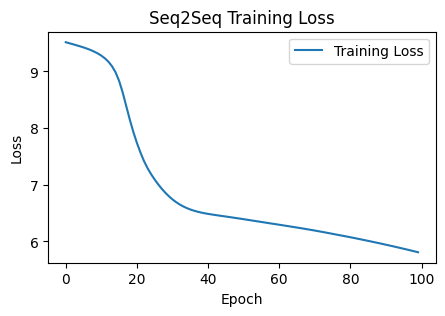

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for module in (embedding, encoder_lstm, decoder_lstm, output_fc):
    module.to(device)

X, Y_in, Y_out = X.to(device), Y_in.to(device), Y_out.to(device)

optimizer_seq = torch.optim.Adam(list(embedding.parameters()) + list(encoder_lstm.parameters()) + list(decoder_lstm.parameters()) + list(output_fc.parameters()))
criterion_seq = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])

loss_history = []
for epoch in range(100):
    encoder_lstm.train(); decoder_lstm.train()
    enc_emb = embedding(X)
    _, (h, c) = encoder_lstm(enc_emb)
    dec_emb = embedding(Y_in)
    dec_out, _ = decoder_lstm(dec_emb, (h, c))
    logits = output_fc(dec_out)
    loss = criterion_seq(logits.view(-1, len(vocab)), Y_out.view(-1))
    optimizer_seq.zero_grad()
    loss.backward()
    optimizer_seq.step()
    loss_history.append(loss.item())
    if (epoch+1) % 20 == 0:
        print(f"[Abstractive] Epoch {epoch+1}: Loss {loss.item():.4f}")

# Visualize training loss
plt.figure(figsize=(5,3))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Seq2Seq Training Loss')
plt.legend()
plt.show()


### 4.3 Generating a Summary (Inference)
We use greedy decoding: starting with <sos>, the decoder produces one word at a time until <eos> is generated or the max length is reached.

In [16]:
def generate_summary(text):
    embedding.eval(); encoder_lstm.eval(); decoder_lstm.eval(); output_fc.eval()

    # Tokenize, encode, and pad input
    tokens = encode(tokenize(text))[:max_article_len]
    tokens = pad(tokens, max_article_len)
    inp = torch.tensor(tokens, dtype=torch.long, device=device).unsqueeze(0)

    with torch.no_grad():
        enc_emb = embedding(inp)
        _, (h, c) = encoder_lstm(enc_emb)

    generated = []
    dec_input = torch.tensor([[vocab["<sos>"]]], dtype=torch.long, device=device)

    for _ in range(max_summary_len):
        with torch.no_grad():
            dec_emb = embedding(dec_input)
            dec_out, (h, c) = decoder_lstm(dec_emb, (h, c))
            logits = output_fc(dec_out.squeeze(1))
            next_tok = torch.argmax(logits, dim=-1).item()

        if next_tok == vocab["<eos>"]:
            break

        generated.append(next_tok)
        dec_input = torch.tensor([[next_tok]], dtype=torch.long, device=device)

    # Inverse mapping: index to token
    inv_vocab = {idx: tok for tok, idx in vocab.items()}
    summary_tokens = [inv_vocab[idx] for idx in generated]

    return " ".join(summary_tokens)


## 5. Evaluation with ROUGE
Finally, we evaluate our abstractive summarizer using simple ROUGE-1 and ROUGE-2 F1-scores.

In [17]:
def rouge_score(gen, ref):
    # Tokenize and clean
    gen_tokens = re.findall(r"\w+", gen.lower())
    ref_tokens = re.findall(r"\w+", ref.lower())
    # ROUGE-1 calculation
    overlap1 = set(gen_tokens) & set(ref_tokens)
    r1_recall = len(overlap1) / (len(set(ref_tokens)) or 1)
    r1_precision = len(overlap1) / (len(set(gen_tokens)) or 1)
    r1_f1 = 2 * r1_recall * r1_precision / (r1_recall + r1_precision + 1e-8)
    # ROUGE-2 calculation (bigrams)
    gen_bigrams = set(zip(gen_tokens, gen_tokens[1:]))
    ref_bigrams = set(zip(ref_tokens, ref_tokens[1:]))
    overlap2 = gen_bigrams & ref_bigrams
    r2_recall = len(overlap2) / (len(ref_bigrams) or 1)
    r2_precision = len(overlap2) / (len(gen_bigrams) or 1)
    r2_f1 = 2 * r2_recall * r2_precision / (r2_recall + r2_precision + 1e-8)
    return {"ROUGE-1 F1": r1_f1, "ROUGE-2 F1": r2_f1}

# Evaluate a few samples
for i in range(5):
    ref = summaries[i]
    gen = generate_summary(articles[i])
    scores = rouge_score(gen, ref)
    print(f"Sample {i+1} -> {scores}")


Sample 1 -> {'ROUGE-1 F1': 0.0, 'ROUGE-2 F1': 0.0}
Sample 2 -> {'ROUGE-1 F1': 0.0, 'ROUGE-2 F1': 0.0}
Sample 3 -> {'ROUGE-1 F1': 0.05405405352812273, 'ROUGE-2 F1': 0.0}
Sample 4 -> {'ROUGE-1 F1': 0.15384615180473374, 'ROUGE-2 F1': 0.0}
Sample 5 -> {'ROUGE-1 F1': 0.05555555501543211, 'ROUGE-2 F1': 0.0}


## 6. Conclusion
In this project, you learned how to:

- Load a real summarization dataset (CNN/DailyMail) using Hugging Face’s datasets.

- Preprocess text—tokenization, vocabulary building, and sequence padding.

- Implement Extractive Summarization with a sentence classifier (using a heuristic label).

- Implement Abstractive Summarization using an encoder-decoder LSTM model with teacher forcing.

- Evaluate summary quality using simple ROUGE metrics.

You're now set to experiment further! Consider expanding the dataset size, fine-tuning hyperparameters, or adding components (like attention mechanisms) for improved performance. Happy coding and summarizing!